[View in Colaboratory](https://colab.research.google.com/github/JozeeLin/google-tensorflow-exercise/blob/master/improving_neural_net_performance.ipynb)

# 训练神经网络：最佳做法
本部分介绍了反向传播算法的失败案例，以及正则化神经网络的常见方法。

## 失败案例
很多常见情况都会导致反向传播算法出错。

### 梯度消失
较低层(更接近输入)的梯度可能会变得非常小。在深度网络中，计算这些梯度时，可能涉及许多小项的乘积。

当较低层的梯度逐渐消失到0时，这些层的训练速度回非常缓慢，甚至不再训练。
 
ReLU激活函数有助于防止梯度消失。(HOW?)

### 梯度爆炸
如果网络中的权重过大，则较低层的梯度会涉及许多大项的乘积。在这种情况下，梯度就会爆炸：梯度过大导致难以收敛。

批标准化可以降低学习率，因而有助于防止梯度爆炸。

### ReLU单元消失
一旦ReLU单元的加权和低于0，ReLU单元就可能会停滞。它会输出对网络输出没有任何贡献的0激活，而梯度在反向传播算法期间将无法再从中流过。由于梯度的来源被切断，ReLU的输入可能无法作出足够的改变来使加权和回复到0以上。

降低学习速率有助于防止ReLU单元消失。

### 丢弃正则化
这是称为丢弃的另一种形式的正则化，可用于神经网络。其工作原理是，在梯度下降法的每一步中随机丢弃一些网络单元。丢弃得越多，正则化效果就越强：

- 0.0=无丢弃正则化
- 1.0=丢弃所有内容。模型学不到任何规律
- 0.0和1.0之间的值更有用

# 训练神经网络：编程练习
## 提高神经网络性能

学习目标：通过将特征标准化并应用各种优化算法来提高神经网络的性能
注意：本练习中介绍的优化方法并非专门针对神经网络；这些方法可有效改进大多数类型的模型。

### 设置：
首先，加载数据


In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

In [0]:
def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [0]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

In [7]:
# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2645.1,539.8,1433.3,501.9,3.9,2.0
std,2.1,2.0,12.6,2180.5,422.1,1150.7,386.0,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1460.0,297.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,28.0,2128.5,434.0,1168.0,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3159.0,649.0,1728.0,606.0,4.8,2.3
max,41.9,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.9,2640.3,538.4,1420.7,499.7,3.9,2.0
std,2.1,2.0,12.6,2178.8,420.2,1140.9,381.0,1.9,1.2
min,32.6,-124.3,1.0,18.0,5.0,3.0,4.0,0.5,0.0
25%,33.9,-121.8,18.0,1466.8,294.0,786.0,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2126.0,433.0,1164.5,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3122.2,647.0,1704.0,605.0,4.7,2.3
max,42.0,-114.6,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.0
std,116.3
min,15.0
25%,118.8
50%,179.5
75%,265.3
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.0
std,115.2
min,25.0
25%,121.5
50%,181.4
75%,264.3
max,500.0


### 训练神经网络

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 171.04
  period 01 : 174.88
  period 02 : 156.47
  period 03 : 152.44
  period 04 : 140.20
  period 05 : 134.93
  period 06 : 121.74
  period 07 : 121.20
  period 08 : 111.63
  period 09 : 110.35
Model training finished.
Final RMSE (on training data):   110.35
Final RMSE (on validation data): 109.44


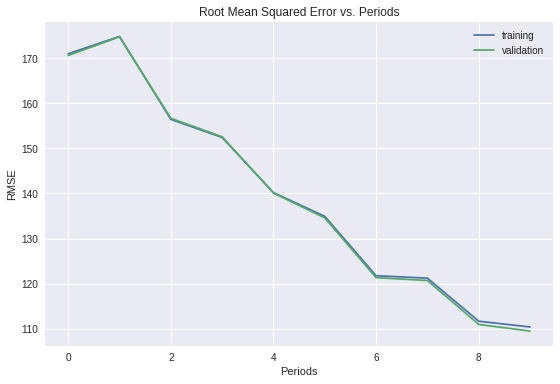

In [12]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 线性缩放
将输入标准化以使其位于(-1,1)范围内可能是一种良好的标准做法。这样一来，SGD在一个维度中采用很大步长(或者在另一维度中采用很小步长)时不会受阻。数值优化的爱好者可能会注意到，这种做法与使用预调节器的想法是有联系的。

In [0]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

### 任务1：使用线性缩放将特征标准化
将输入标准化到(-1,1)这一范围内
花费5分钟左右的时间来训练和评估新标准化的数据。

一般来说，当输入特征大致位于相同范围时，神经网络的训练效果最好。

对您的标准化数据进行健全性检查。

由于标准化会只用最小值和最大值，我们必须确保在整个数据集中一次性完成该操作

我们之所以可以这样做，是因为我们所有的数据都在一个DataFrame钟。如果我们有多个数据集，则最好从训练集中导出标准化参数，然后一下相同方式将其应用于测试集。

Training model...
RMSE (on training data):
  period 00 : 171.56
  period 01 : 114.29
  period 02 : 102.42
  period 03 : 85.35
  period 04 : 76.37
  period 05 : 74.30
  period 06 : 72.96
  period 07 : 72.15
  period 08 : 71.70
  period 09 : 71.30
Model training finished.
Final RMSE (on training data):   71.30
Final RMSE (on validation data): 70.88


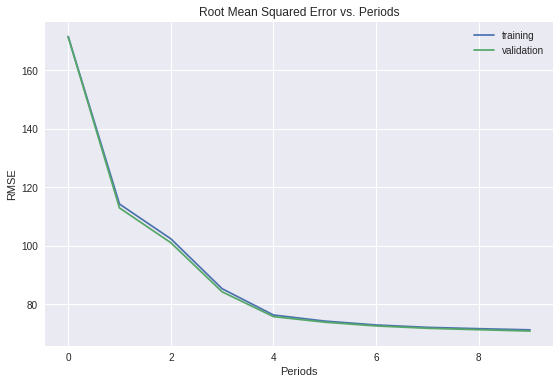

In [14]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### 任务2：尝试其他优化器

使用AdaGrad和Adam优化器并对比其效果

AdaGrad优化器是一种备选方案。AdaGrad的核心是灵活地修改模型中每个系数的学习率，从而单调降低有效的学习率。该优化器对于凸优化问题非常有效，但不一定适合非凸优化问题的神经网络训练。你可以通过指定AdagradOptimizer(而不是GradientDescentOptimizer)来使用AdaGrad。请注意，对于AdaGrad，你可能需要使用较大的学习率。

对于非凸优化问题，Adam有时比AdaGrad更有效。要使用Adam，请调用tf.train.AdamOptimizer方法。此方法将几个可选超参数作为参数，但我们的解决方案仅指定其中一个。在应用设置中，应谨慎指定和调整可选超参数。

Training model...
RMSE (on training data):
  period 00 : 92.53
  period 01 : 73.89
  period 02 : 73.46
  period 03 : 70.90
  period 04 : 73.68
  period 05 : 70.02
  period 06 : 69.45
  period 07 : 70.36
  period 08 : 69.59
  period 09 : 69.58
Model training finished.
Final RMSE (on training data):   69.58
Final RMSE (on validation data): 69.31


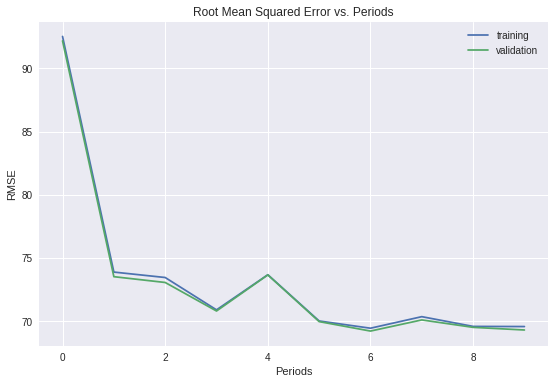

In [16]:
_,adagrad_training_losses, adagrad_validation_losses=train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10,10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets= validation_targets
)

Training model...
RMSE (on training data):
  period 00 : 210.14
  period 01 : 125.69
  period 02 : 116.56
  period 03 : 109.11
  period 04 : 94.06
  period 05 : 78.61
  period 06 : 71.63
  period 07 : 70.59
  period 08 : 70.03
  period 09 : 69.84
Model training finished.
Final RMSE (on training data):   69.84
Final RMSE (on validation data): 69.56


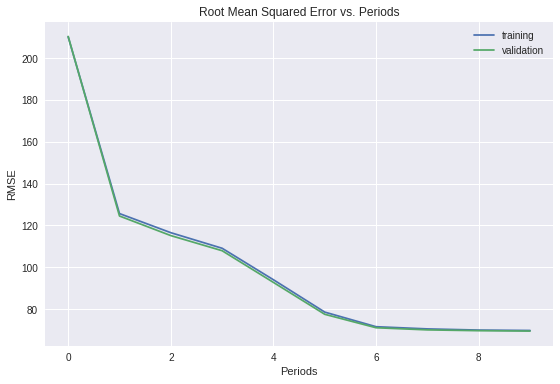

In [17]:
_,adam_training_losses,adam_validation_losses=train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10,10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets
)

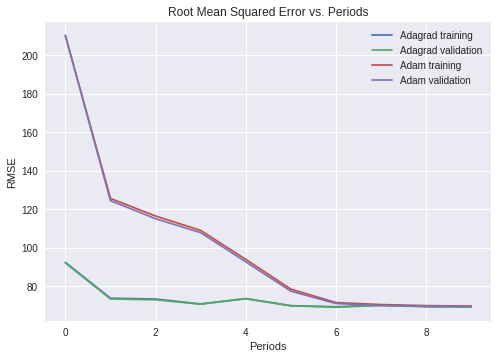

In [18]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

### 任务3：尝试其他标准方法

尝试对各种特征使用其他标准化方法，以进一步提高性能

如果仔细查看转换后数据的汇总统计信息，你可能会注意到，对某些特征进行线性缩放会使其聚集到接近-1的位置。

例如，很多特征的中位数约为-0.8，而不是0.0

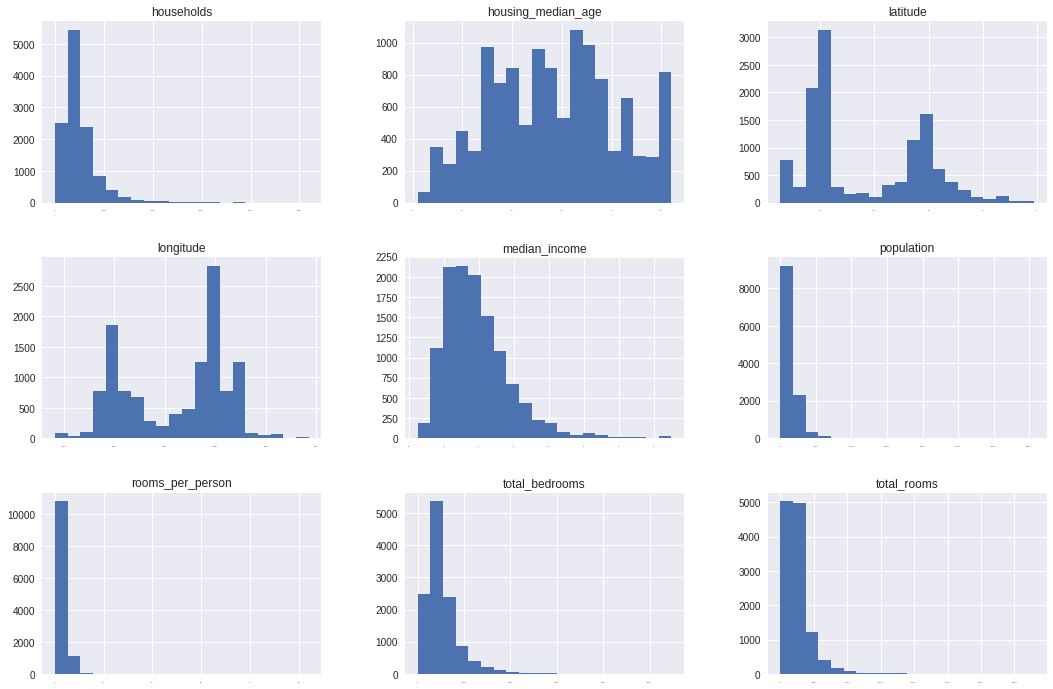

In [19]:
_ = training_examples.hist(bins=20, figsize=(18,12), xlabelsize=2)

In [20]:
type(training_examples)

pandas.core.frame.DataFrame

In [0]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x-mean)/std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x>threshold else 0))

通过前面对各个特征的分布进行可视化发现：

households、median_income和total_bedrooms在对数空间内均呈现为正态分布

如果latitude、longitude和housing_median_age像之前一样进行线性缩放，效果可能会更好。

population、totalRooms和rooms_per_person具有几个极端离群值。这些值似乎过于极端，以至于我们无法利用对数标准化处理这些离群值，因此，我们直接截掉这些值。

Training model...
RMSE (on training data):
  period 00 : 89.79
  period 01 : 72.56
  period 02 : 71.43
  period 03 : 70.42
  period 04 : 70.34
  period 05 : 69.62
  period 06 : 69.50
  period 07 : 69.56
  period 08 : 69.17
  period 09 : 69.16
Model training finished.
Final RMSE (on training data):   69.16
Final RMSE (on validation data): 68.93


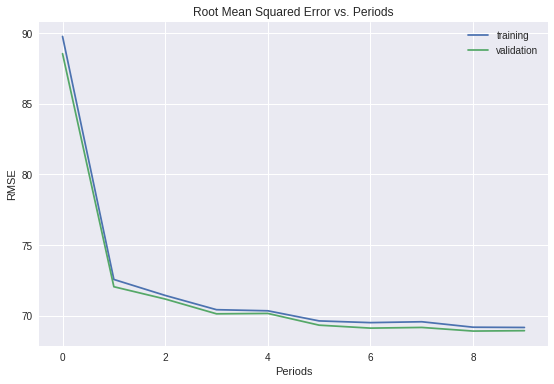

In [22]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### 仅使用维度和经度特征
训练仅适用维度和经度作为特征的神经网络模型。

房地产商喜欢说，地段是房价的唯一重要特征。我们来看看能够通过训练仅使用维度和经度作为特征的模型来证实这一点。

只有我们神经网络模型可以从维度和经度中学会复杂的非线性规律，才能达到我们想要的效果

注意：我们可能需要一个网络结构，其层数比我们之前的练习中使用的要多。

Training model...
RMSE (on training data):
  period 00 : 108.50
  period 01 : 105.38
  period 02 : 103.73
  period 03 : 101.60
  period 04 : 101.11
  period 05 : 100.59
  period 06 : 100.27
  period 07 : 100.12
  period 08 : 99.77
  period 09 : 99.76
Model training finished.
Final RMSE (on training data):   99.76
Final RMSE (on validation data): 98.78


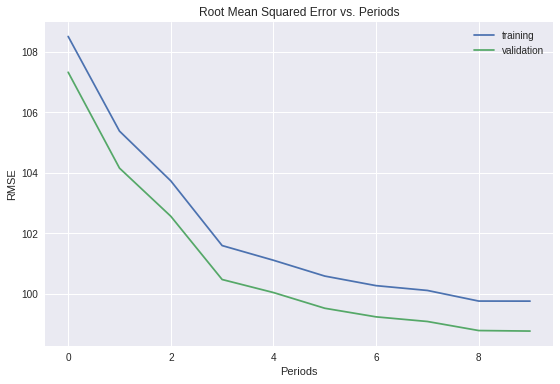

In [23]:
#最好是维度和经度保持标准化状态

def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)